In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Attrition Data.csv')
df.head()

,Age,Attrition,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,WorkLifeBalance,YearsAtCompany
0,41,Yes,Sales,1,2,Life Sciences,2,4,Single,5993,8,1,6
1,49,No,Research & Development,8,1,Life Sciences,3,2,Married,5130,1,3,10
2,37,Yes,Research & Development,2,2,Other,4,3,Single,2090,6,3,0
3,33,No,Research & Development,3,4,Life Sciences,4,3,Married,2909,1,3,8
4,27,No,Research & Development,2,1,Medical,1,2,Married,3468,9,3,2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      1470 non-null   int64 
 1   Attrition                1470 non-null   object
 2   Department               1470 non-null   object
 3   DistanceFromHome         1470 non-null   int64 
 4   Education                1470 non-null   int64 
 5   EducationField           1470 non-null   object
 6   EnvironmentSatisfaction  1470 non-null   int64 
 7   JobSatisfaction          1470 non-null   int64 
 8   MaritalStatus            1470 non-null   object
 9   MonthlyIncome            1470 non-null   int64 
 10  NumCompaniesWorked       1470 non-null   int64 
 11  WorkLifeBalance          1470 non-null   int64 
 12  YearsAtCompany           1470 non-null   int64 
dtypes: int64(9), object(4)
memory usage: 149.4+ KB


In [5]:
sns.set()
def continousFeatureAnalysis(data,column):
    """Function to see the distribution of column feature and detect outlier"""
    plt.figure(figsize=(15,5))
    ax = sns.kdeplot(data = data, x = column,color='black')
    ax.axvline(data[column].mean(),linestyle ='--',color='green',label='mean')
    ax.axvline(data[column].median(),linestyle ='--',color='red',label='median')
    ax.axvline(data[column].min(),linestyle ='--',color='blue',label='min')
    ax.axvline(data[column].max(),linestyle ='--',color='orange',label='max')
    ax.axvline(data[column].describe()['25%'],linestyle ='--',color='yellow',label='First Quartile')
    ax.axvline(data[column].describe()['75%'],linestyle ='--',color='brown',label='Third Quartile')
    plt.legend(loc='upper right')
    plt.title(column,fontdict={'fontsize':15},color='blue')
    plt.plot()

In [6]:
continous_columns = df.describe().columns.tolist()
categorical_columns = df.describe(include='O').columns.tolist()
continous_columns , categorical_columns

(['Age',
  'DistanceFromHome',
  'Education',
  'EnvironmentSatisfaction',
  'JobSatisfaction',
  'MonthlyIncome',
  'NumCompaniesWorked',
  'WorkLifeBalance',
  'YearsAtCompany'],
 ['Attrition', 'Department', 'EducationField', 'MaritalStatus'])

# UniVariante Analysis

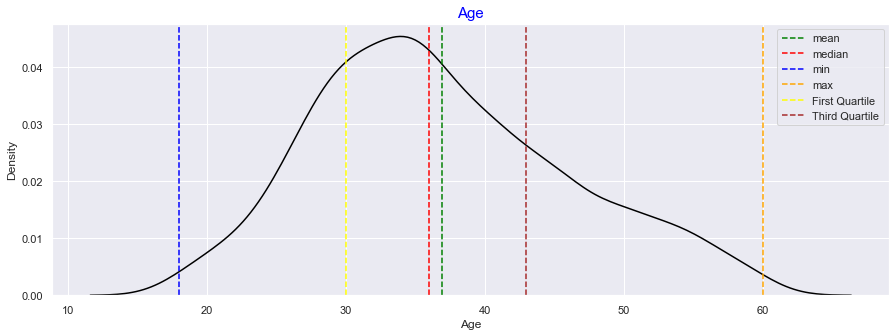

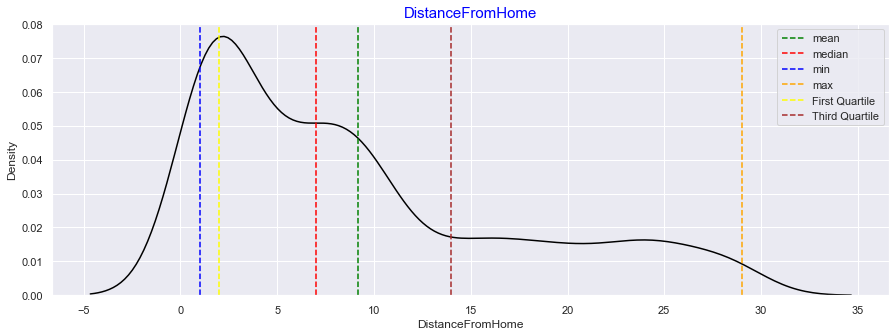

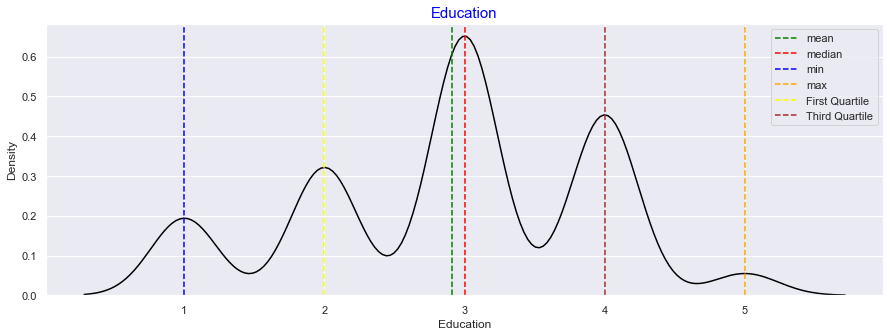

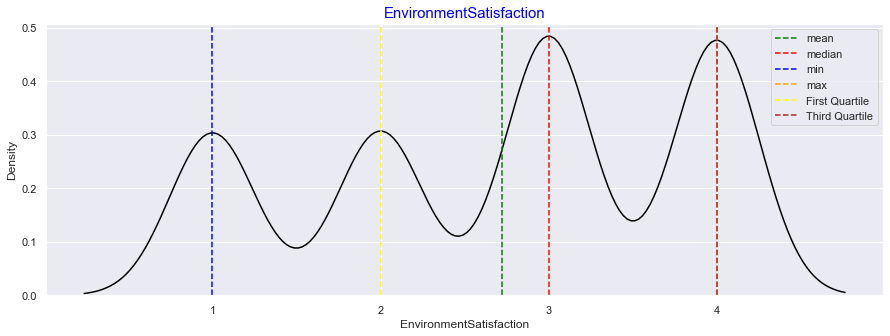

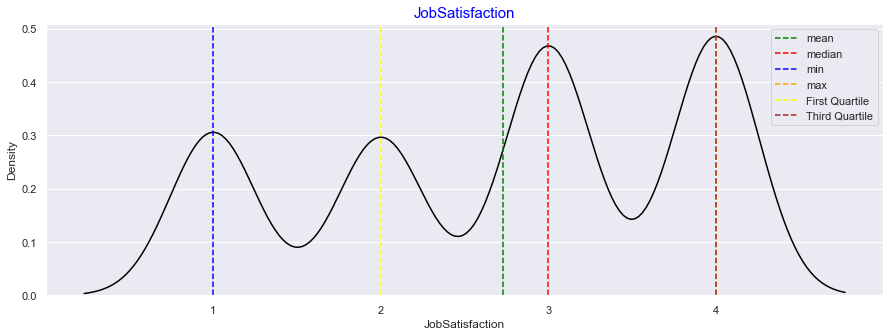

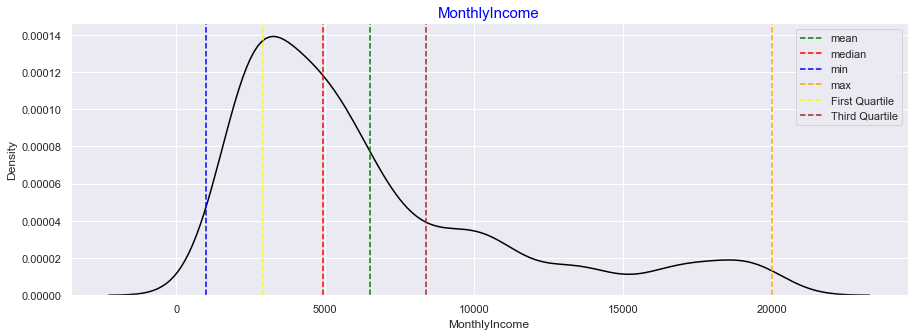

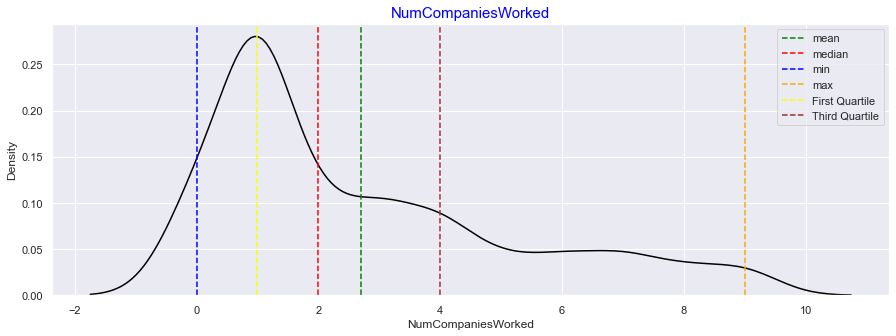

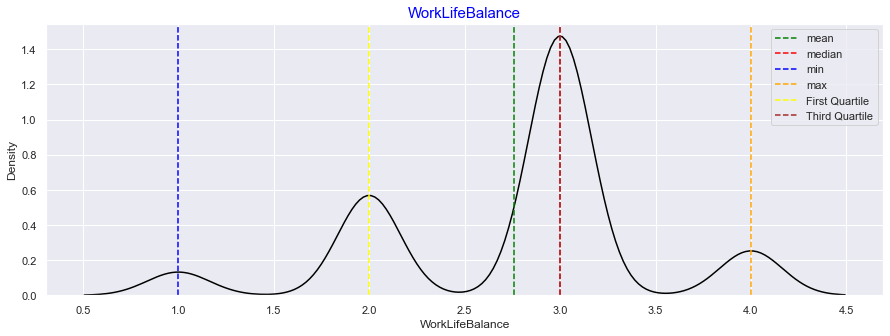

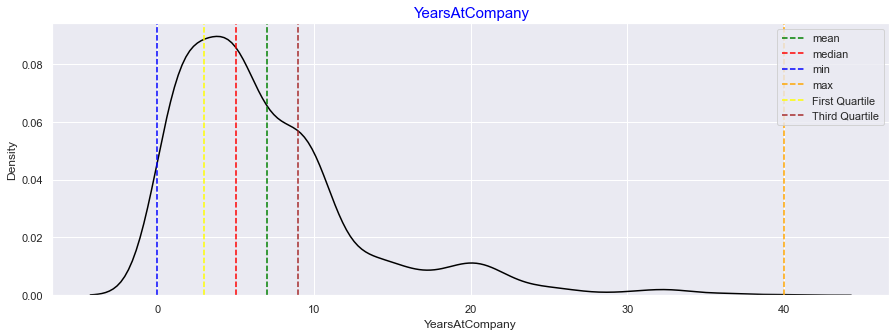

In [7]:
for c_col in continous_columns:
    continousFeatureAnalysis(df,c_col)
    
    
# Notes :
# 1. 'Age' normally distributed and most of employees from 25 to 45.
# 2. Most of the employees are near the company.
# 3. Most of Employees are graduated on "Bachelor" degree then 'Masters' then 'college' then 'Below College' and few 'Doctors'.
# 4. Most of them rated very high and high in 'EnvironmentSatisfaction'.
# 5. Most of them rated very high and high in 'JobSatisfaction'.
# 6. Most of them with low Salaries, Range of 'MonthlyIncome' lies between [2000, 6000].
# 7. Most of them hired directly or worked in one or two company before joining the company.
# 8. Most of who can balance between 'WorkLifeBalance' are in better and good levels.
# 9. Most of the employees spent between 0 and 12 years in the company.

In [8]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha='center')

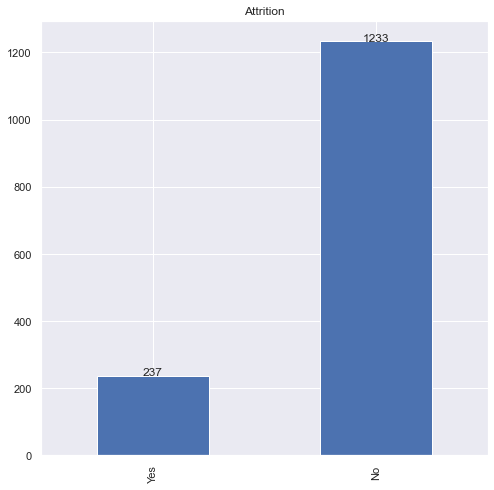

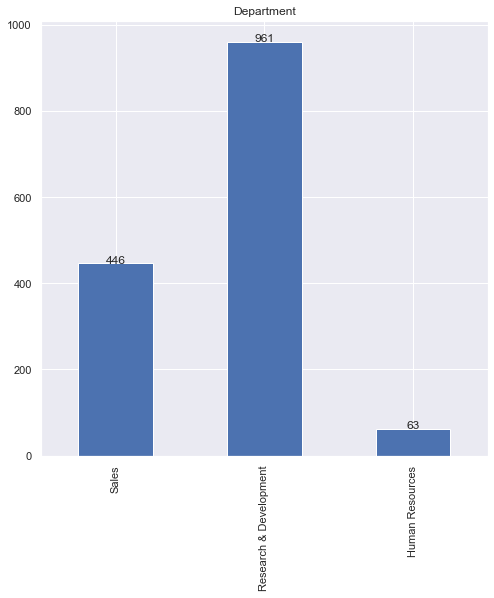

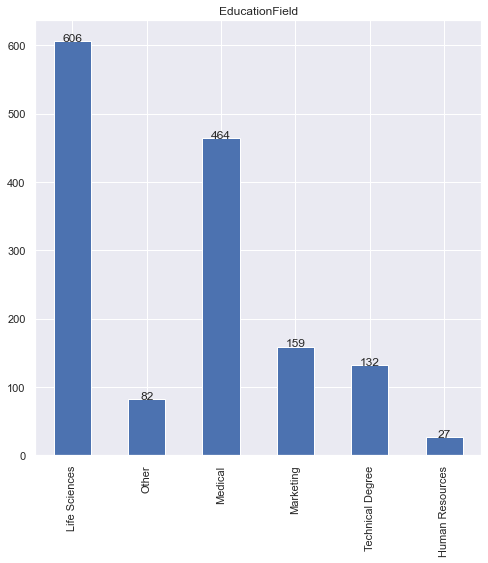

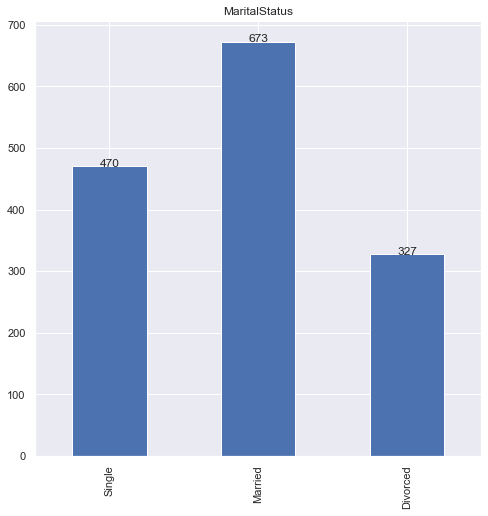

In [9]:
for cat_col in categorical_columns:
    plt.figure(figsize=(8,8))
    g = df[cat_col].value_counts(sort=False)
    g.plot(kind='bar')
    plt.title(cat_col)
    addlabels(g, g.values)
    plt.show()
    
# Notes:
# 1. Most of the employees are not attrited by work force.
# 2. Most of them lies in the 'Research & Development' department
# 3. 'EducationField' are mostly in the 'life sciences' and 'medical'
# 4. Most of them are married then single.

# MultiVariante Analysis

In [10]:
def showCorrelationOnData(data,*,threshold=None):
    sns.set_theme(style="white")
    corr = data.corr()
    if threshold:
        corr = data.corr()[(data.corr() >= threshold) | (data.corr() <= -threshold)]
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(10, 10))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,square=True, linewidths=.5, \
                cbar_kws={"shrink": .5}, annot=True, annot_kws={"fontsize":12})
    plt.show()

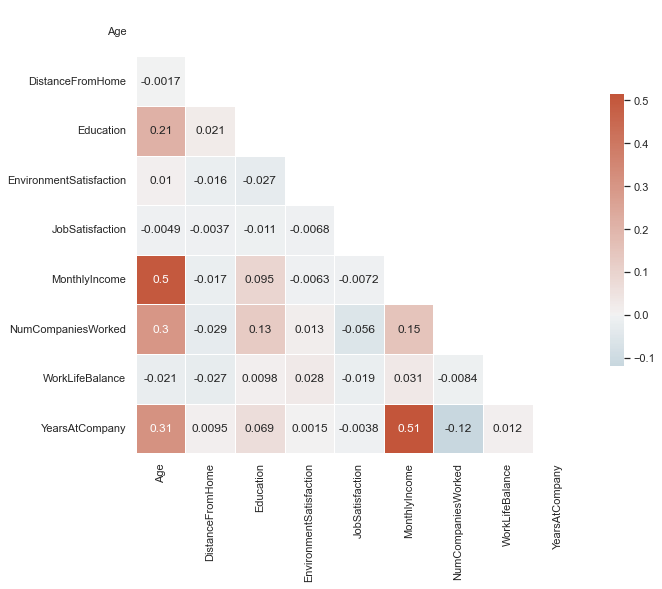

In [11]:
showCorrelationOnData(df)

# Notes:
# 1. there's semi-relation between the yearsAtCompany and MonthlyIncome.
# 2. there's semi-relation between the Age and MonthlyIncome.

In [12]:
categorical_columns, continous_columns

(['Attrition', 'Department', 'EducationField', 'MaritalStatus'],
 ['Age',
  'DistanceFromHome',
  'Education',
  'EnvironmentSatisfaction',
  'JobSatisfaction',
  'MonthlyIncome',
  'NumCompaniesWorked',
  'WorkLifeBalance',
  'YearsAtCompany'])

# BiVariante Analysis

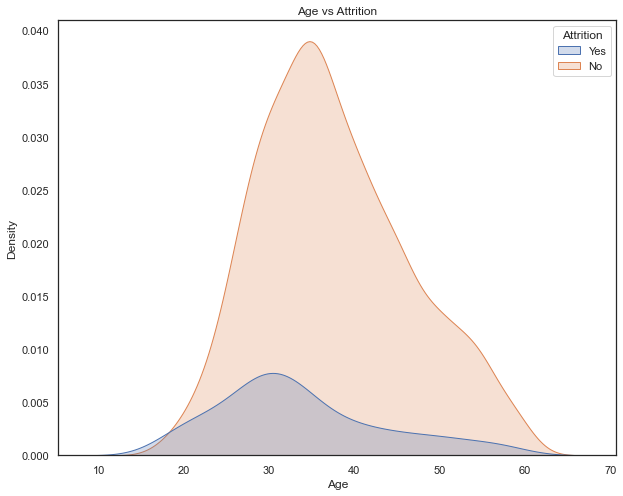

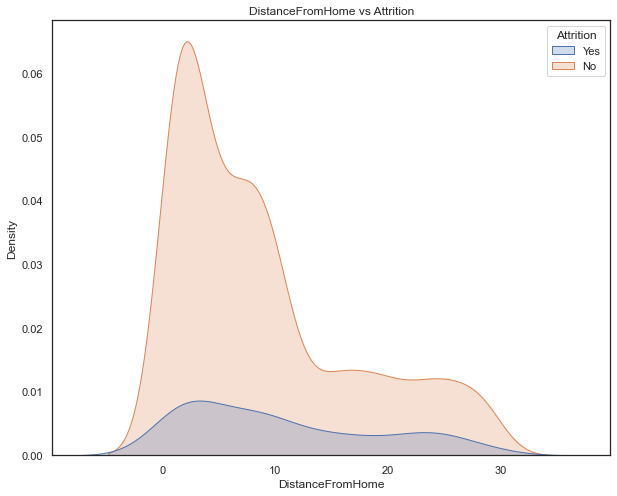

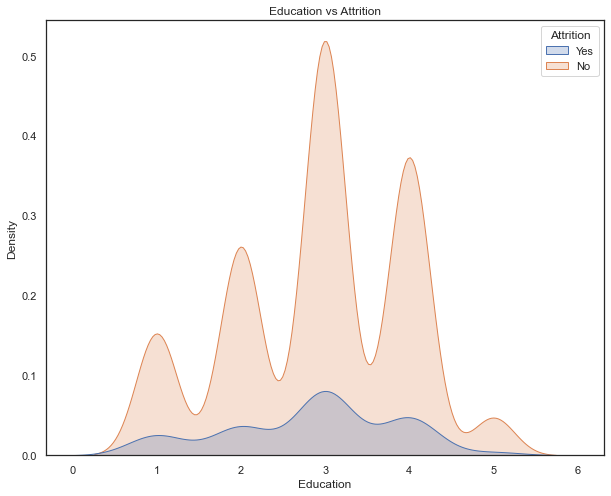

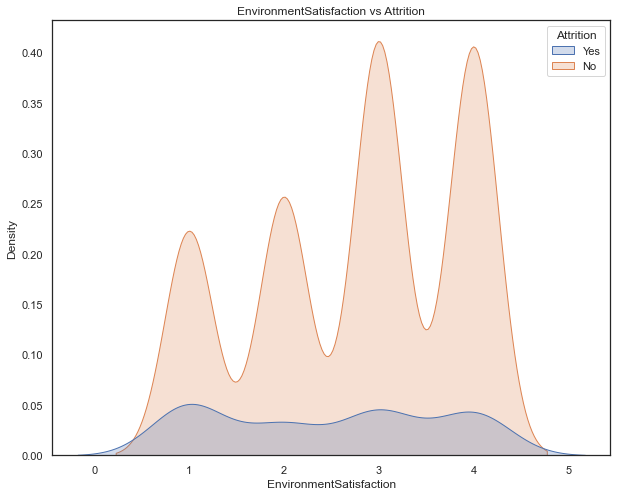

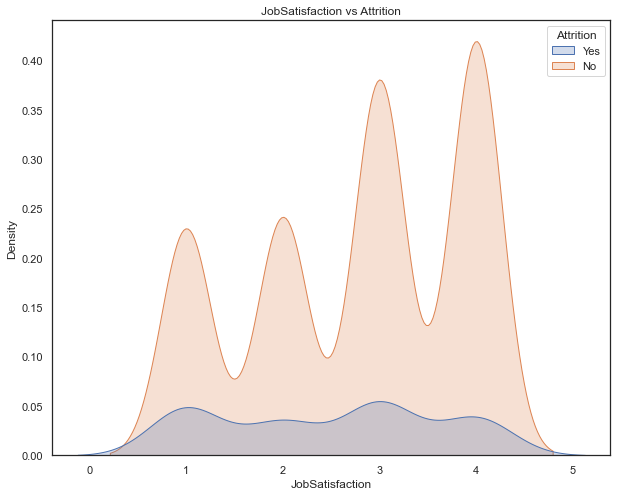

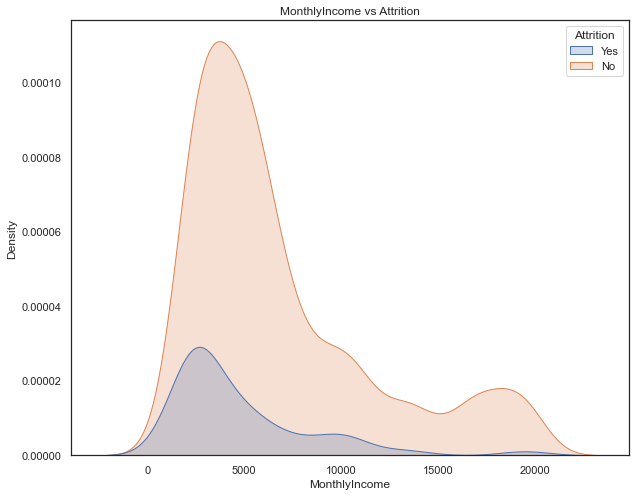

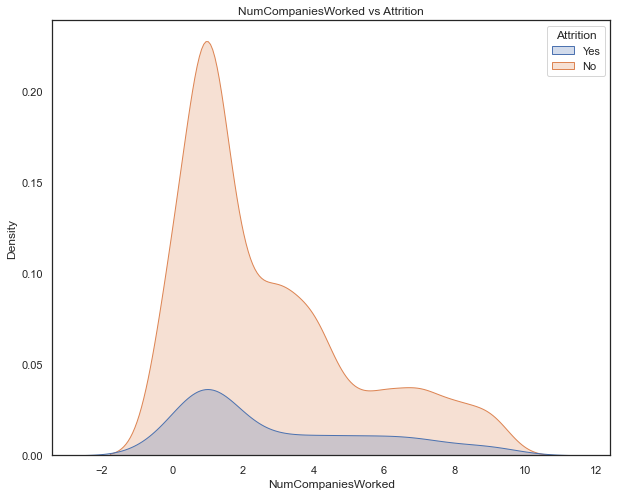

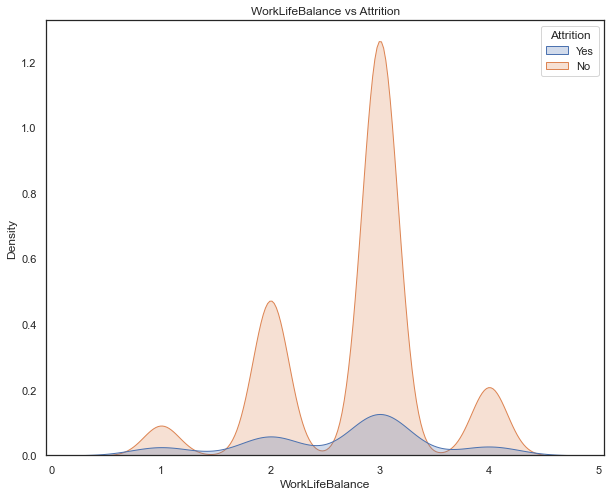

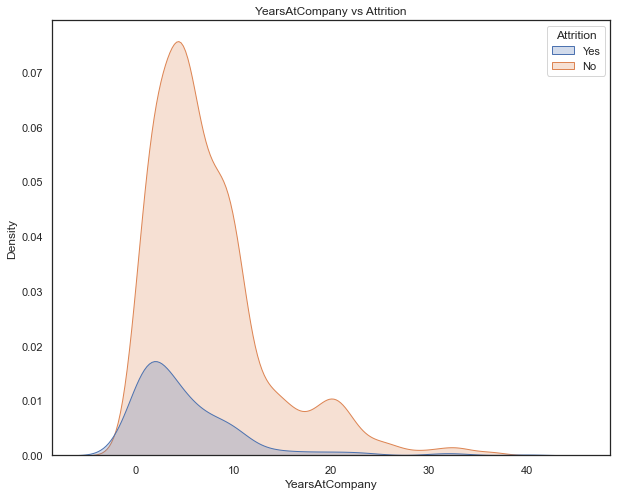

In [13]:
# first Column in Categorical = ['Attrition', 'Department', 'EducationField', 'MaritalStatus']
# 'Attrition'
for ccol in continous_columns:
    plt.figure(figsize=(10,8))
    sns.kdeplot(df[ccol],hue=df['Attrition'], fill=True)
    plt.title(ccol + ' vs ' + 'Attrition')
    plt.show()
    

# Attrition levels are very low on all features
# but we can say that most of who is suffer from work load in:
# 'Age' between 25 to 35.
# 'DistanceFromHome' around 3.
# 'Education' lies in 'Below College' 
# 'EnvironmentSatisfaction' are 'high' and 'low'
# 'MonthlyIncome' lies around 3000.
# 'NumberOfCampanies' is 1.
# 'WorkLifeBalance' is better.
# spent 3 or 4 years in the company.

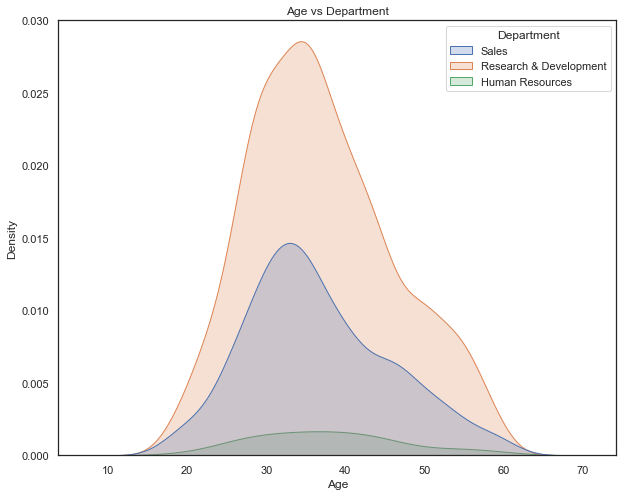

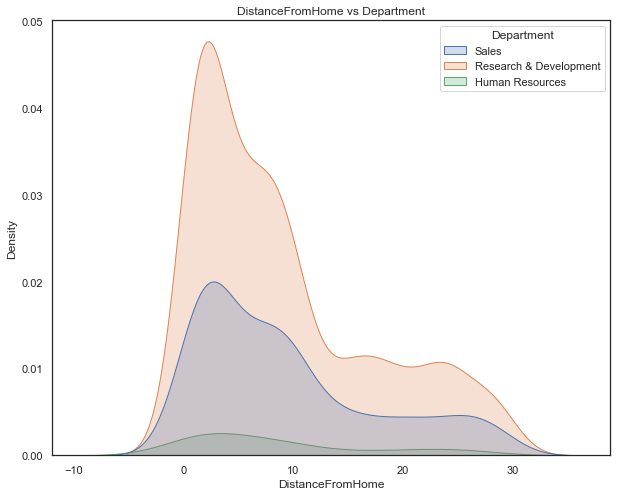

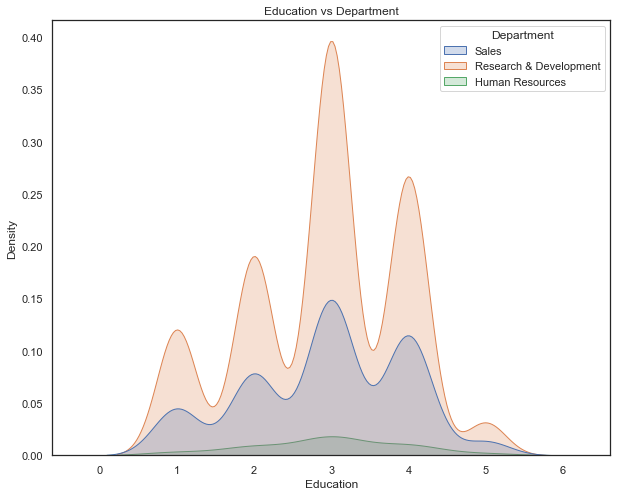

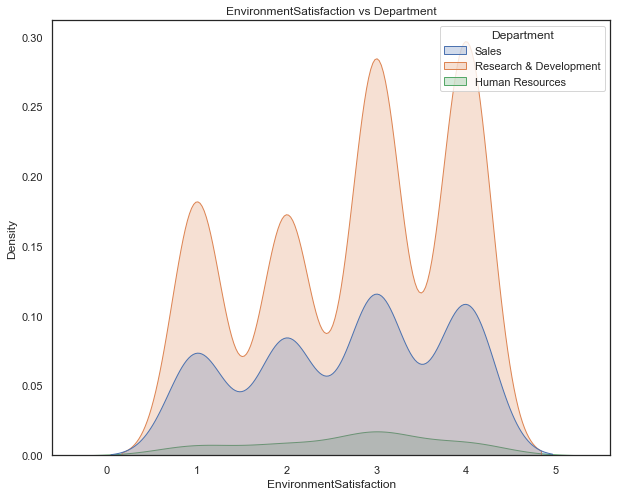

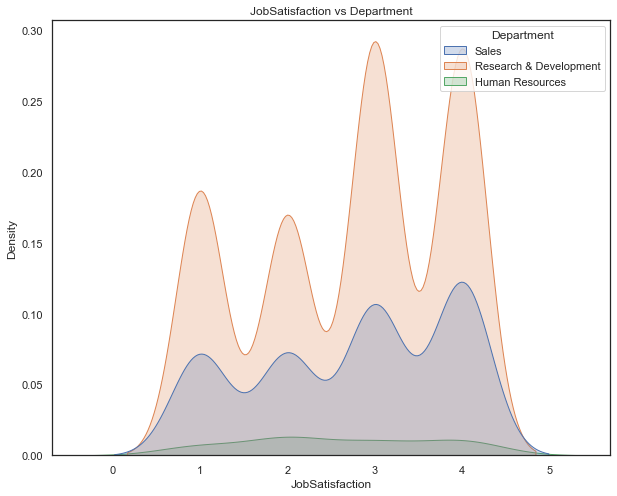

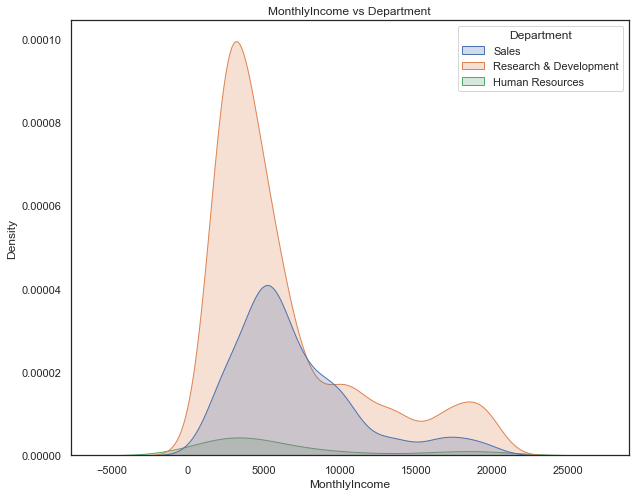

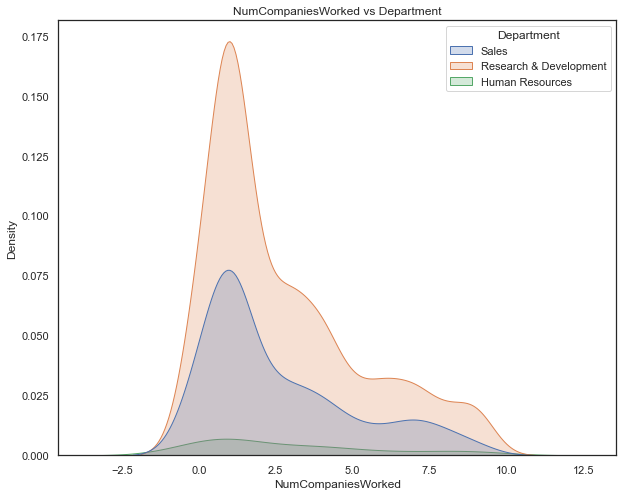

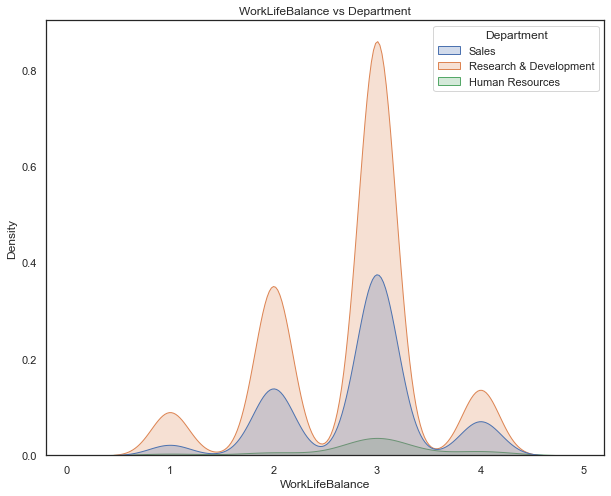

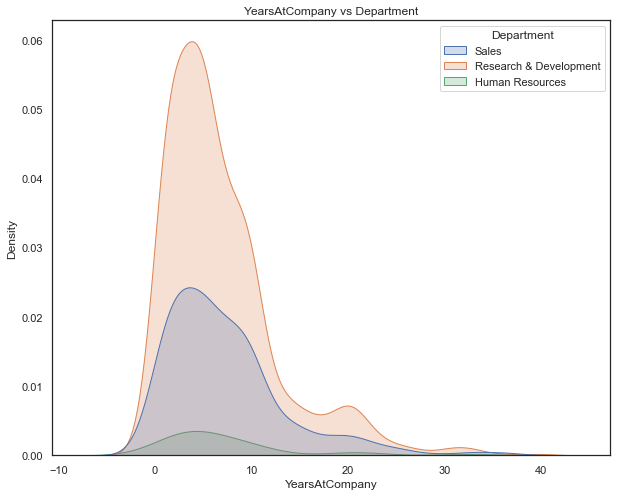

In [14]:
# Second Column in Categorical = ['Attrition', 'Department', 'EducationField', 'MaritalStatus']
# 'Department'
for ccol in continous_columns:
    plt.figure(figsize=(10,8))
    sns.kdeplot(df[ccol],hue=df['Department'], fill=True)
    plt.title(ccol + ' vs ' + 'Department')
    plt.show()
    

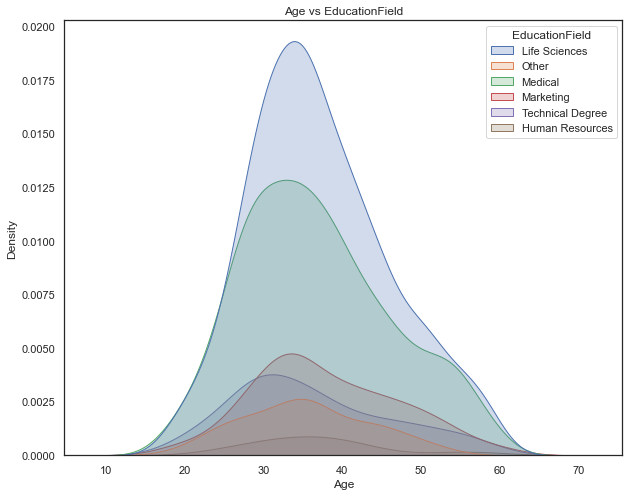

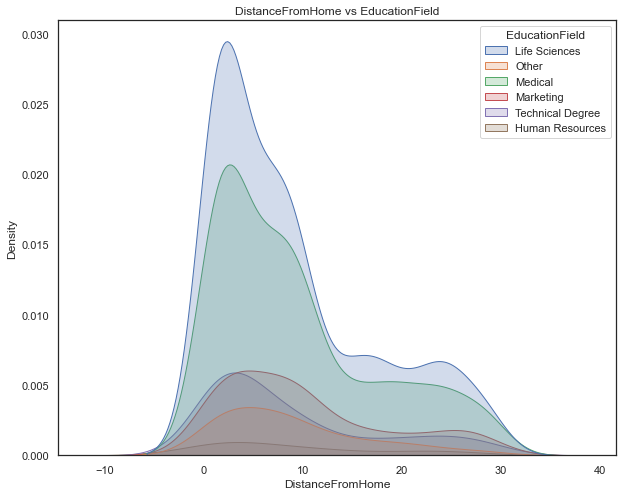

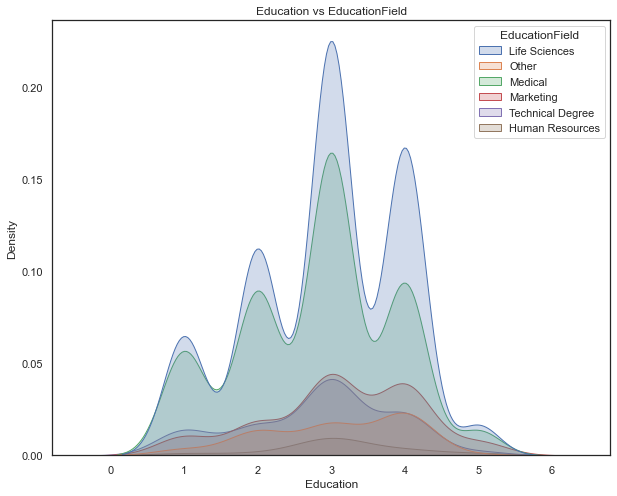

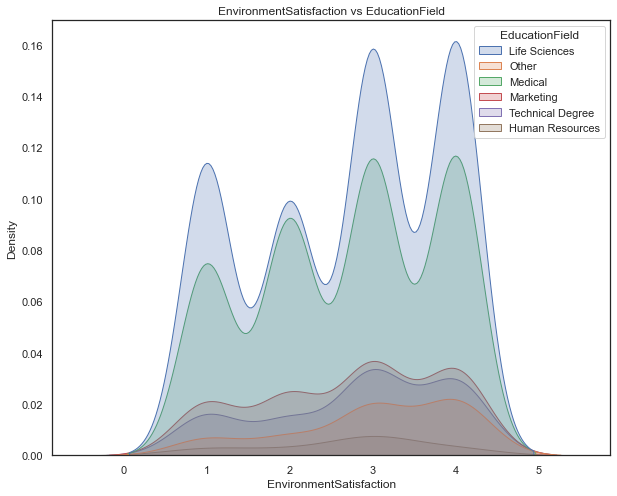

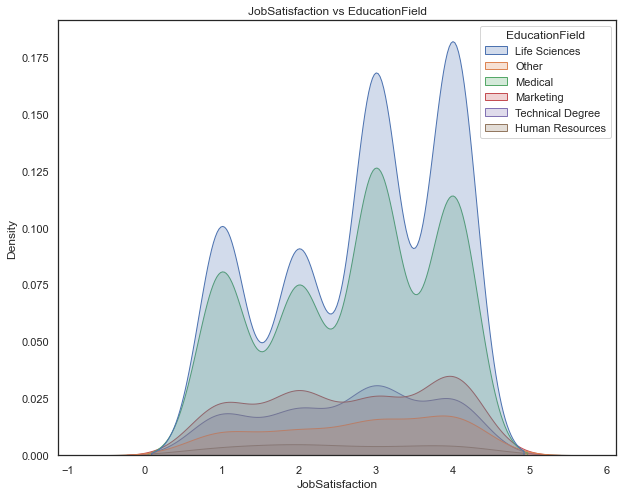

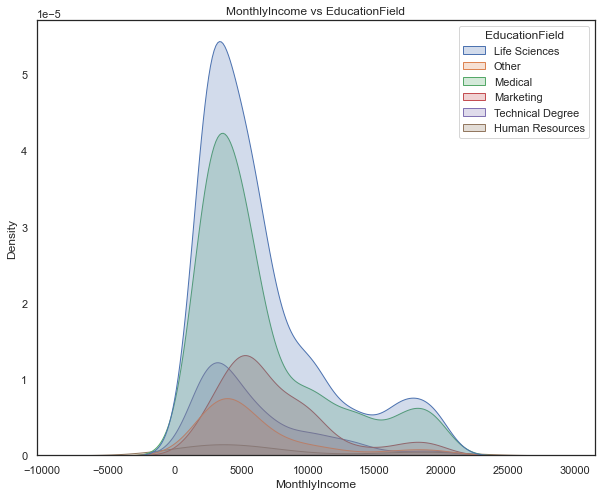

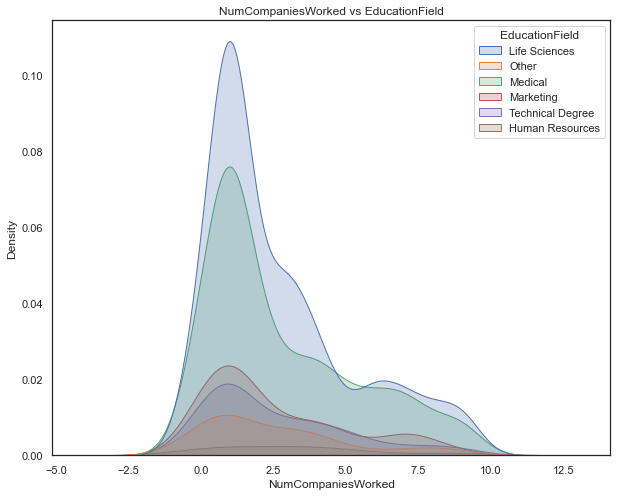

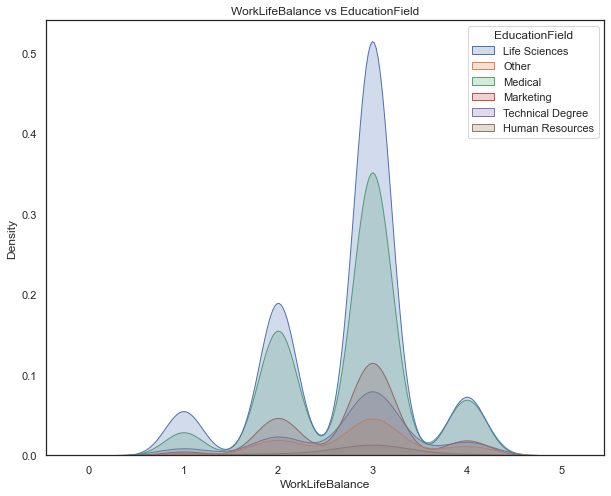

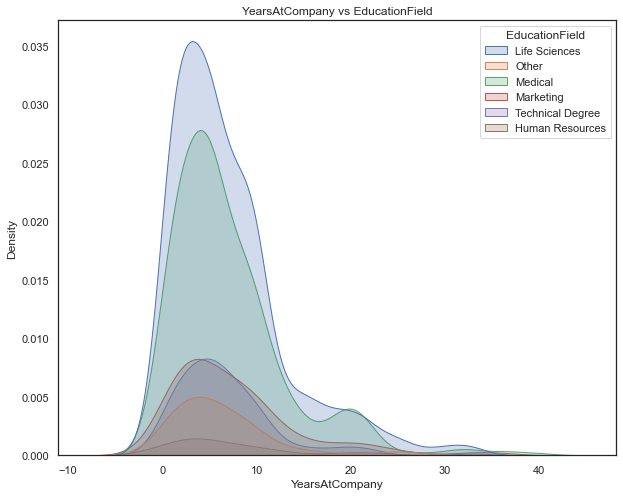

In [15]:
# Third Column in Categorical = ['Attrition', 'Department', 'EducationField', 'MaritalStatus']
# 'EducationField'
for ccol in continous_columns:
    plt.figure(figsize=(10,8))
    sns.kdeplot(df[ccol],hue=df['EducationField'], fill=True)
    plt.title(ccol + ' vs ' + 'EducationField')
    plt.show()
    

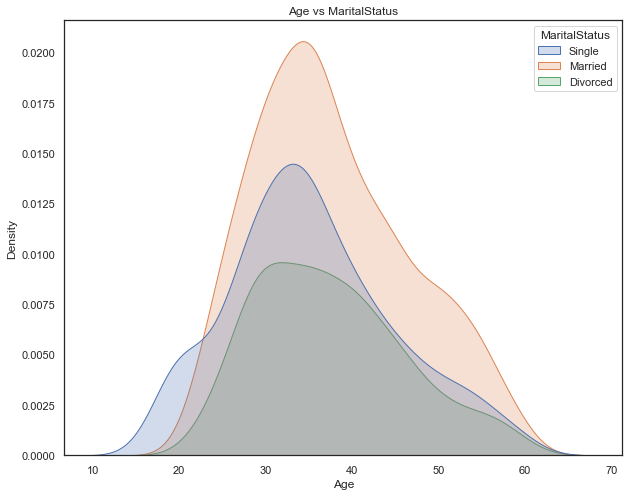

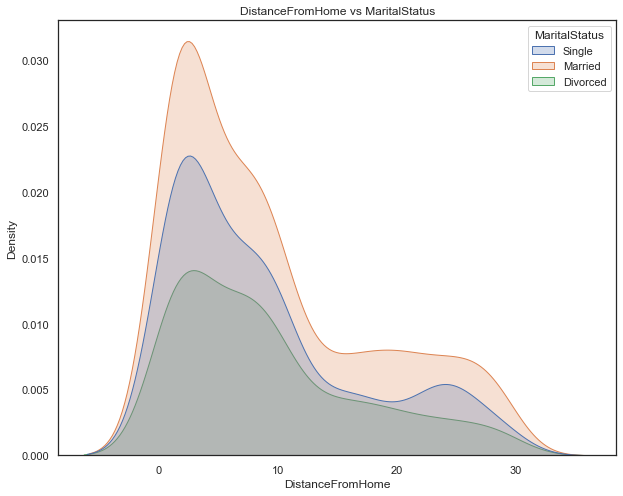

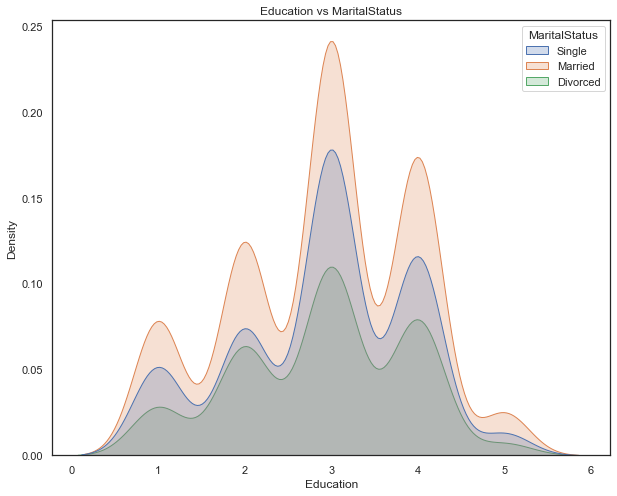

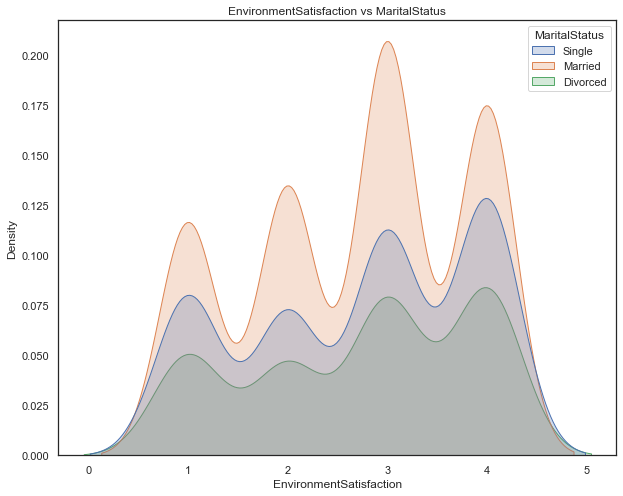

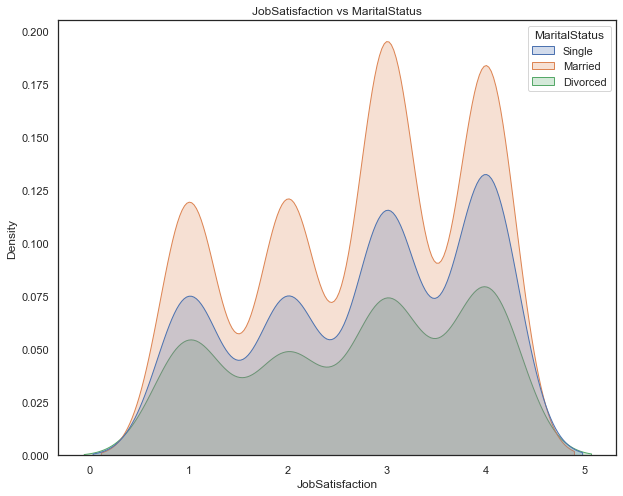

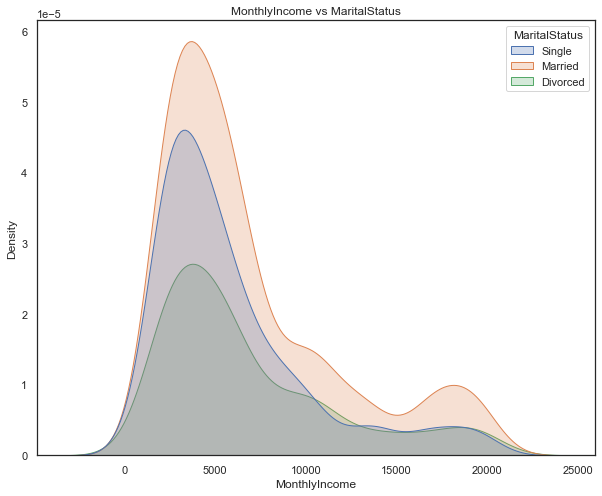

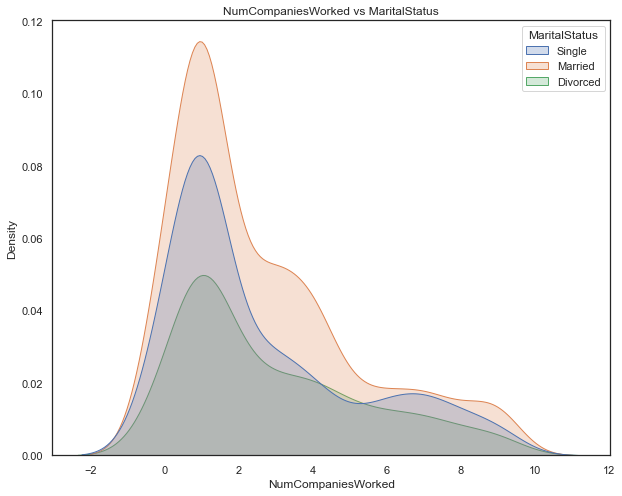

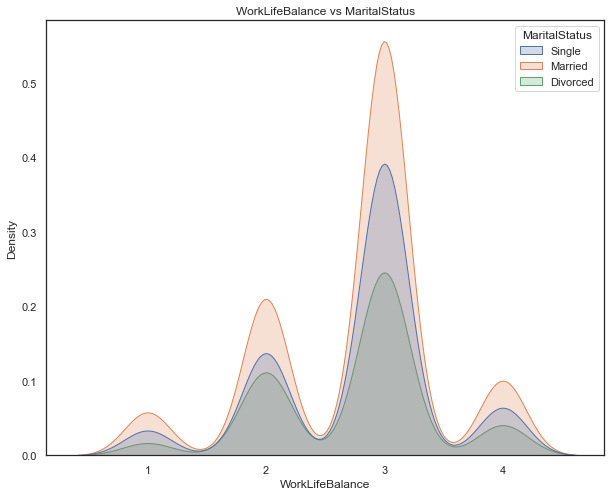

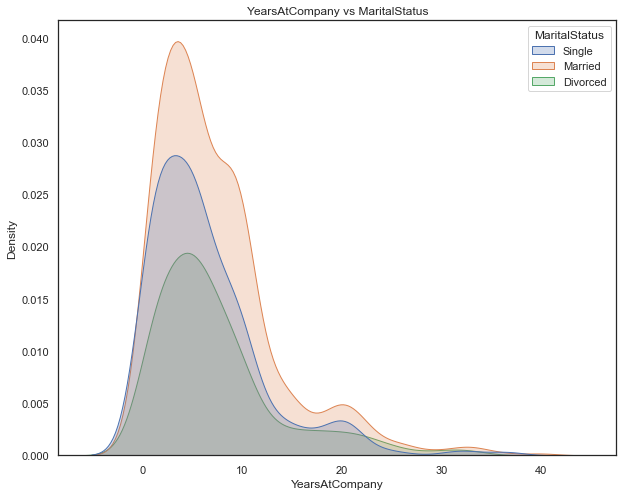

In [16]:
# last Column in Categorical = ['Attrition', 'Department', 'EducationField', 'MaritalStatus']
# 'MaritalStatus'
for ccol in continous_columns:
    plt.figure(figsize=(10,8))
    sns.kdeplot(df[ccol],hue=df['MaritalStatus'], fill=True)
    plt.title(ccol + ' vs ' + 'MaritalStatus')
    plt.show()
    

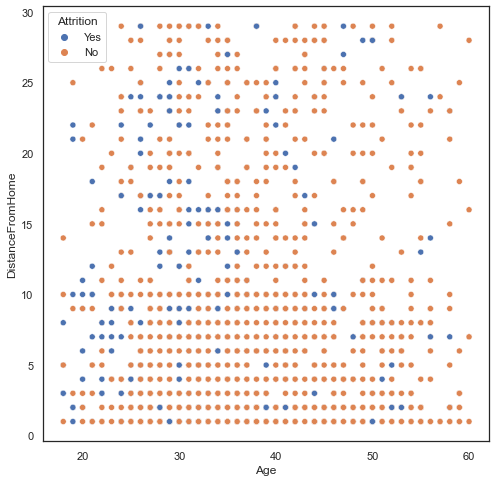

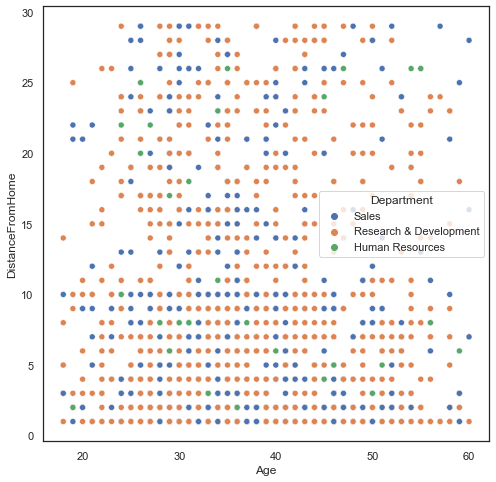

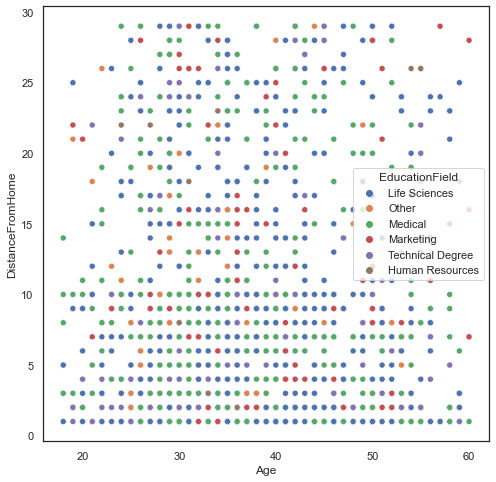

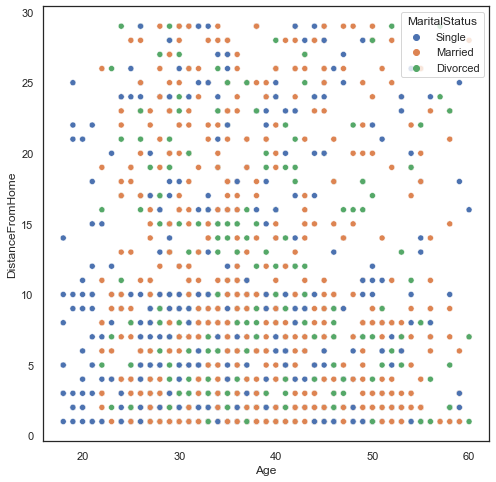

In [17]:
c1 = continous_columns[0]
c2 = continous_columns[1]
for cat_col in categorical_columns:
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=c1, y=c2, data=df, hue=cat_col)
    plt.show()

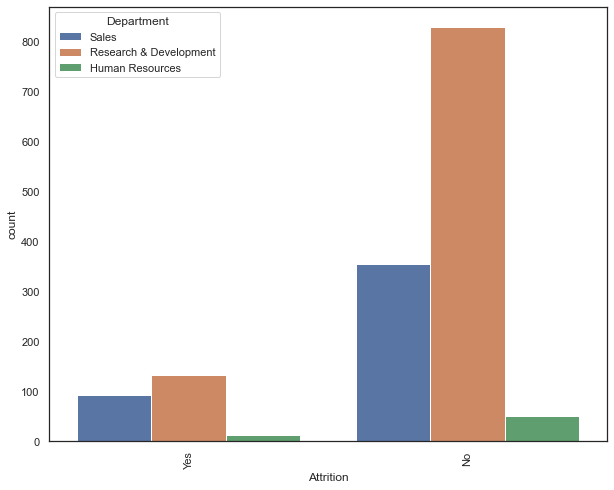

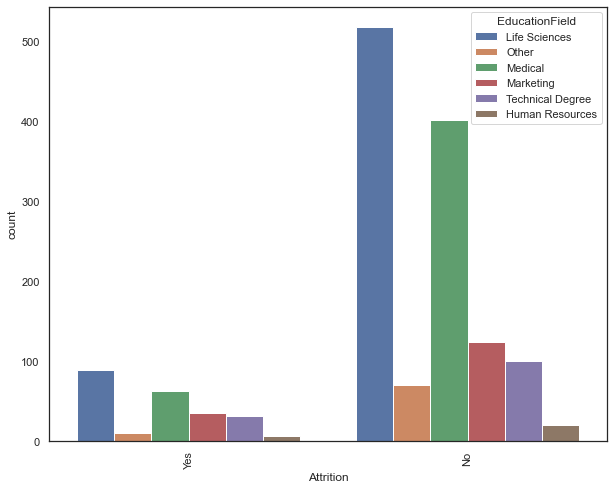

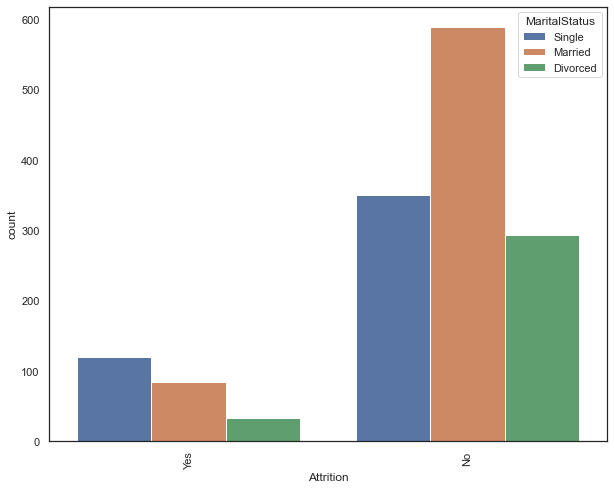

In [18]:
for n in range(len(categorical_columns)):
    first_col = categorical_columns[0]
    if categorical_columns[n] != first_col:
        plt.figure(figsize=(10,8))
        sns.countplot(x=first_col,data=df,hue=categorical_columns[n])
        plt.xticks(rotation=90)
        plt.show()

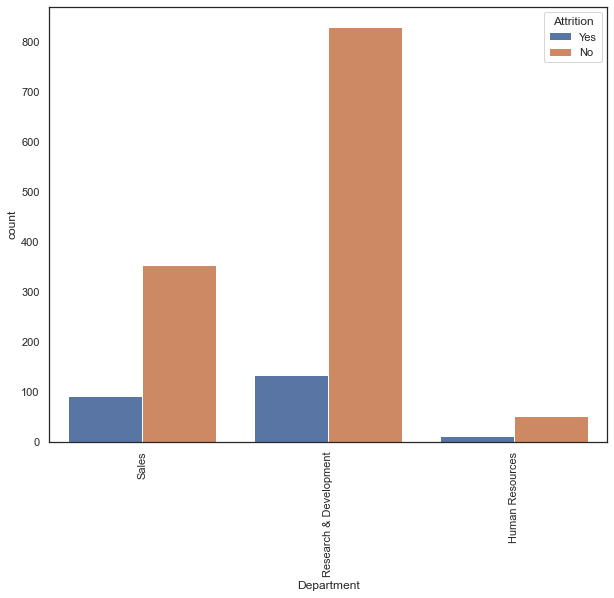

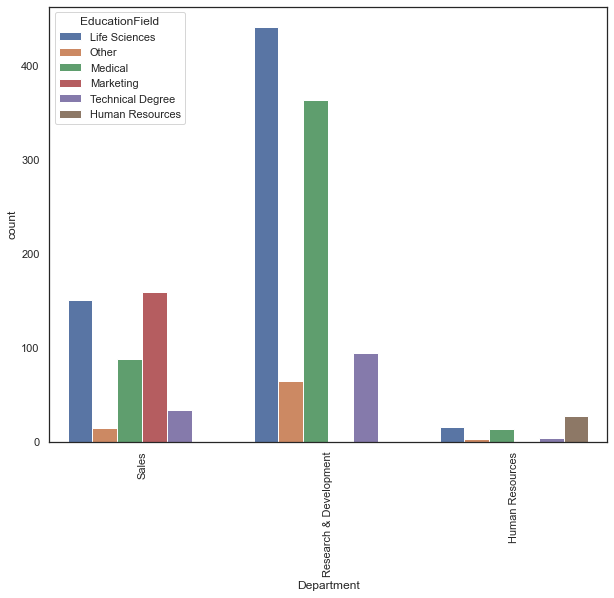

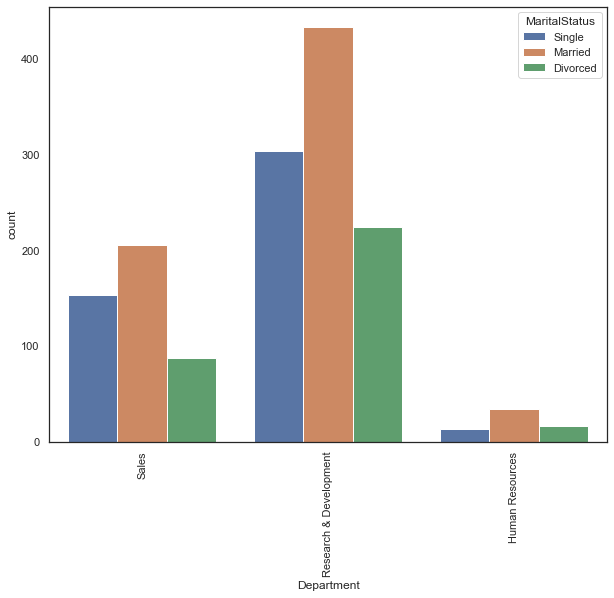

In [19]:
for n in range(len(categorical_columns)):
    first_col = categorical_columns[1]
    if categorical_columns[n] != first_col:
        plt.figure(figsize=(10,8))
        sns.countplot(x=first_col,data=df,hue=categorical_columns[n])
        plt.xticks(rotation=90)
        plt.show()

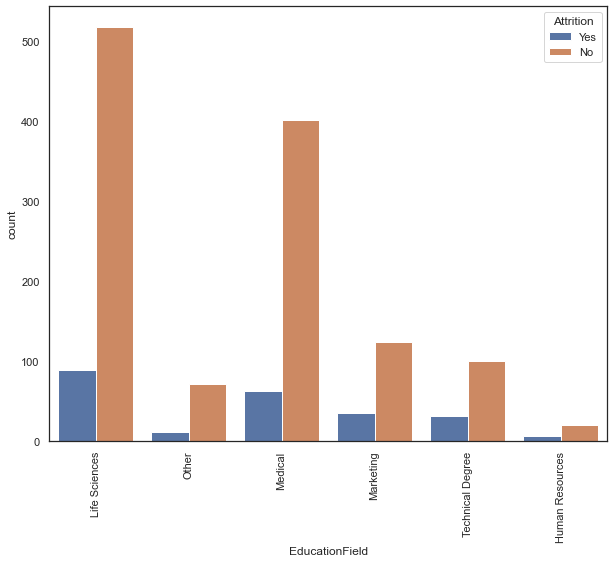

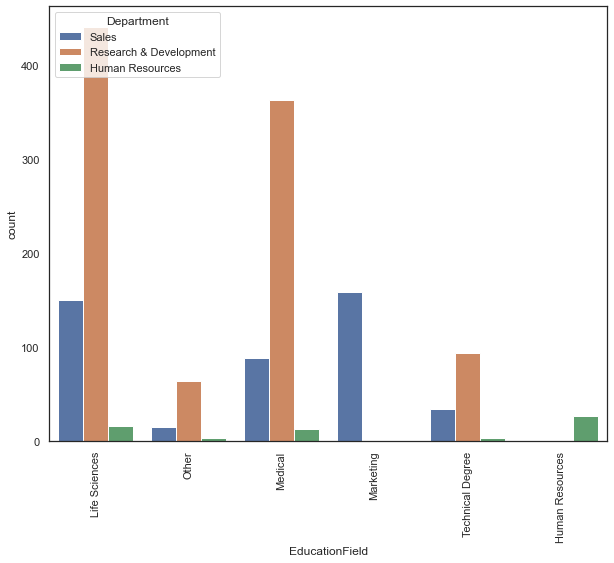

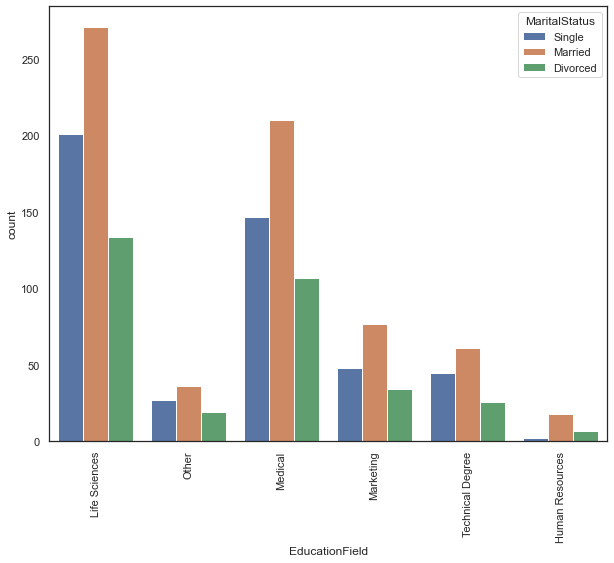

In [20]:
for n in range(len(categorical_columns)):
    first_col = categorical_columns[2]
    if categorical_columns[n] != first_col:
        plt.figure(figsize=(10,8))
        sns.countplot(x=first_col,data=df,hue=categorical_columns[n])
        plt.xticks(rotation=90)
        plt.show()

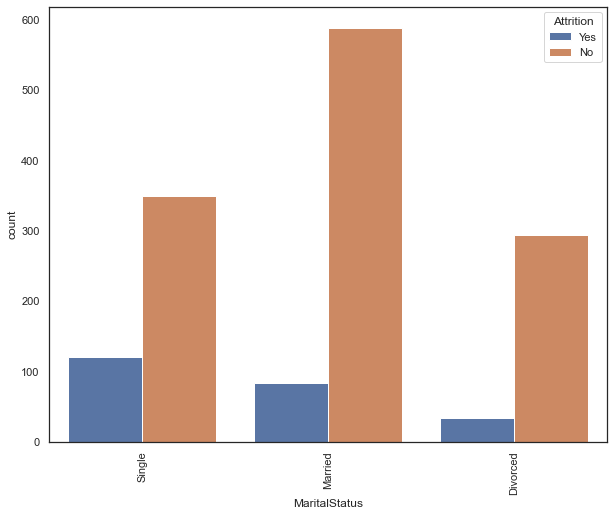

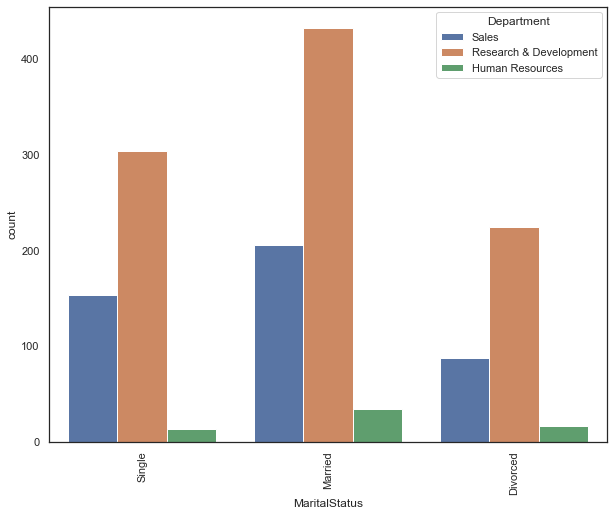

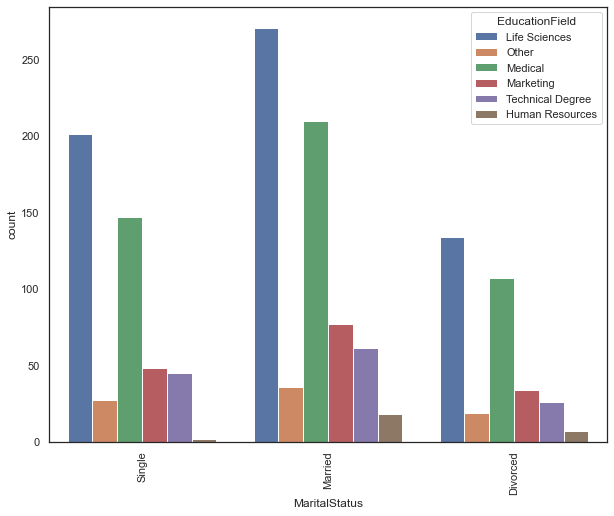

In [21]:
for n in range(len(categorical_columns)):
    first_col = categorical_columns[3]
    if categorical_columns[n] != first_col:
        plt.figure(figsize=(10,8))
        sns.countplot(x=first_col,data=df,hue=categorical_columns[n])
        plt.xticks(rotation=90)
        plt.show()

# Encoding Categorical Features

In [22]:
# encoding Categoical Columns 
categorical_columns

['Attrition', 'Department', 'EducationField', 'MaritalStatus']

In [23]:
def encodeCatColumn(data, column):
    g = data[column].value_counts()
    dict_g = {}
    n = 0
    for k in g.index:
        dict_g[k] = n
        n += 1
    data[column] = data[column].map(dict_g)
    print(data[column].unique())

In [24]:
for cat_col in categorical_columns:
    encodeCatColumn(df, cat_col)

[1 0]
[1 0 2]
[0 4 1 2 3 5]
[1 0 2]


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Age                      1470 non-null   int64
 1   Attrition                1470 non-null   int64
 2   Department               1470 non-null   int64
 3   DistanceFromHome         1470 non-null   int64
 4   Education                1470 non-null   int64
 5   EducationField           1470 non-null   int64
 6   EnvironmentSatisfaction  1470 non-null   int64
 7   JobSatisfaction          1470 non-null   int64
 8   MaritalStatus            1470 non-null   int64
 9   MonthlyIncome            1470 non-null   int64
 10  NumCompaniesWorked       1470 non-null   int64
 11  WorkLifeBalance          1470 non-null   int64
 12  YearsAtCompany           1470 non-null   int64
dtypes: int64(13)
memory usage: 149.4 KB


# Split Data and Check Imbalanced

In [26]:
X = df.drop('Attrition', axis=1)
y = df['Attrition']

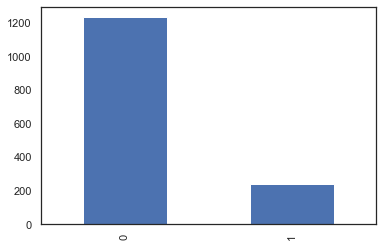

In [27]:
# check Imbalanced Data
y.value_counts().plot(kind='bar')
plt.show()

In [28]:
def counterOccur(column):
    d = {}
    for label,v in zip(column.value_counts().index,column.value_counts()):
        d[label] = v
    return d

In [29]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = counterOccur(y)
print(counter)

{1: 1233, 0: 1233}


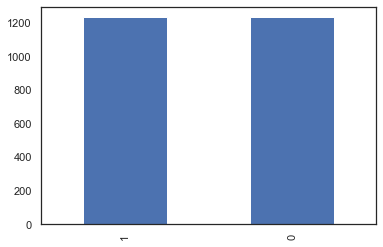

In [30]:
y.value_counts().plot(kind='bar')
plt.show()

# Split Train & Test

In [66]:
def splitData(data,columnOfinterset,*,normalize = False):
    x = data.drop(columnOfinterset,axis=1).values
    y = data[columnOfinterset].values
    y = y.reshape(-1,1)
    if normalize:
        scaler = MinMaxScaler()
        scaler.fit(x)
        x = scaler.fit_transform(x)
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=1)
    return x_train,x_test,y_train,y_test

def checkShape(*args):
    for arg in args:
        print(arg.shape)
        
X_train,X_test,y_train,y_test = splitData(df,'Attrition')
checkShape(X_train,X_test,y_train,y_test)

(1176, 12)
(294, 12)
(1176, 1)
(294, 1)


# MODEL

In [67]:
def classificationAnalysis(model,x1,x2,y1,y2):
    def ClassficationMetricsReport(y1,y2,*,kind='test'):
        error_1 = accuracy_score(y1,y2)
        error_2 = f1_score(y1,y2)
        error_3 = precision_score(y1,y2)
        error_4 = recall_score(y1,y2)
        print(f'\t\taccuracy_score({kind}): {100*error_1:0.3f}%')
        print(f'\t\tf1_score({kind}): {100*error_2:0.3f}%')
        print(f'\t\tprecision_score({kind}): {100*error_3:0.3f}%')
        print(f'\t\trecall_score({kind}): {100*error_4:0.3f}%')
    model.fit(x1,y1.ravel())
    y1_pred = model.predict(x1)
    y2_pred = model.predict(x2)
    print(f'----{model.__class__.__name__} classification-------\n')
    print('\t----Train Error-------\n')
    ClassficationMetricsReport(y1_pred,y1,kind='train')
    print()
    print('\t----Test Error-------\n')
    ClassficationMetricsReport(y2_pred,y2)
    print()
    print()

In [68]:
# split Data - 2
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [69]:
def crossValidationForModels(model,x,y,*,cv,n_jobs=1, scoring='accuracy'):
    score = cross_val_score(model, x, y, cv=cv, n_jobs=n_jobs, scoring=scoring)
    return {model.__class__.__name__ : round(np.mean(score)*100, 2)}

In [70]:
knn = KNeighborsClassifier()
reg = LogisticRegression()
dt = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
svm_model = SVC()
nb = GaussianNB()
algs = [knn, reg, dt, random_forest, svm_model,nb]
reports = []
for alg in algs:
    print('---------------train test split------------------------\n')
    reports.append(classificationAnalysis(alg,X_train,X_test,y_train,y_test))
    print('---------------Cross Validation------------------------\n')
    print(crossValidationForModels(alg, X_train, y_train.ravel(), cv=k_fold))
    print('-------------------------------------------------------\n')

---------------train test split------------------------

----KNeighborsClassifier classification-------

	----Train Error-------

		accuracy_score(train): 85.289%
		f1_score(train): 27.004%
		precision_score(train): 17.877%
		recall_score(train): 55.172%

	----Test Error-------

		accuracy_score(test): 76.531%
		f1_score(test): 10.390%
		precision_score(test): 6.897%
		recall_score(test): 21.053%


---------------Cross Validation------------------------

{'KNeighborsClassifier': 82.06}
-------------------------------------------------------

---------------train test split------------------------

----LogisticRegression classification-------

	----Train Error-------

		accuracy_score(train): 84.949%
		f1_score(train): 2.210%
		precision_score(train): 1.117%
		recall_score(train): 100.000%

	----Test Error-------

		accuracy_score(test): 80.952%
		f1_score(test): 6.667%
		precision_score(test): 3.448%
		recall_score(test): 100.000%


---------------Cross Validation----------------------

In [71]:
# best accuracy from Knn and Gaussian 

# Hyper tunning KNN

In [78]:
model = KNeighborsClassifier()
parameter_dict = {'n_neighbors':[3,9,15],'weights':['uniform', 'distance'],\
                  'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],'leaf_size':[30,35,40]}
gs = GridSearchCV(model,parameter_dict)
gs.fit(X_train,y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [30, 35, 40], 'n_neighbors': [3, 9, 15],
                         'weights': ['uniform', 'distance']})

In [79]:
gs.best_estimator_

KNeighborsClassifier(n_neighbors=15)

In [80]:
gs.best_score_

0.8409880995311937

# Hyper tunning Gaussian

In [81]:
model5 = GaussianNB(priors=None, var_smoothing=1.0)
parameter_dict5 = {'var_smoothing': np.logspace(0,-9, num=100)}
gs5 = GridSearchCV(model5,parameter_dict5)
gs5.fit(X_train,y_train)

GridSearchCV(estimator=GaussianNB(var_smoothing=1.0),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])})

In [82]:
gs5.best_estimator_

GaussianNB(var_smoothing=1.873817422860383e-08)

In [83]:
gs5.best_score_

0.8528957807428779

# i'll resume with knn

In [84]:
final_model = gs5.best_estimator_

In [91]:
test = [[40,1,14,1,1,1,1,1,15000,1,0,0]]
final_model.predict(test)

array([0], dtype=int64)

In [92]:
test = [[40,1,14,1,1,1,1,1,500,1,0,0]]
final_model.predict(test)

array([1], dtype=int64)

In [90]:
X_train[0]

array([  57,    0,   24,    2,    0,    3,    4,    2, 9439,    3,    1,
          5], dtype=int64)

# Features Importance

In [85]:
# Feature importance
import shap
import xgboost
shap.initjs()

In [86]:
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-logloss:0.50332
[100]	test-logloss:0.45851
[200]	test-logloss:0.44880
[267]	test-logloss:0.44799


In [87]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

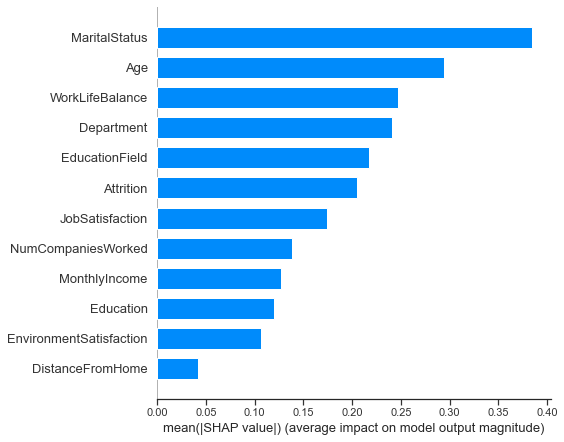

In [88]:
shap.summary_plot(shap_values, X_train, plot_type="bar",feature_names = df.columns.tolist())